In [ ]:
!pip install numpy pandas requests tqdm psutil xgboost folium matplotlib seaborn scikit-learn ucimlrepo optuna shap lime fairlearn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 25.2 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=8b58c15f1c2f9bc0fe45ae0be799ebfb0181d4eac1009cabf943caf7084124b0
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


Mounted at /content/drive


2025-04-14 03:28:57,692 - predictive_policing - INFO - Starting predictive policing pipeline (full_dataset=True)
INFO:predictive_policing:Starting predictive policing pipeline (full_dataset=True)
2025-04-14 03:28:57,693 - predictive_policing - INFO - Loading datasets (full_dataset=True)...
INFO:predictive_policing:Loading datasets (full_dataset=True)...


Fetching Chicago Crime Data: 0rec [00:00, ?rec/s]

2025-04-14 03:30:08,222 - predictive_policing - INFO - Downloaded 1,000,000 records so far...
INFO:predictive_policing:Downloaded 1,000,000 records so far...
2025-04-14 03:31:47,087 - predictive_policing - INFO - Downloaded 2,000,000 records so far...
INFO:predictive_policing:Downloaded 2,000,000 records so far...
2025-04-14 03:33:12,618 - predictive_policing - INFO - Downloaded 3,000,000 records so far...
INFO:predictive_policing:Downloaded 3,000,000 records so far...
2025-04-14 03:34:48,270 - predictive_policing - INFO - Downloaded 4,000,000 records so far...
INFO:predictive_policing:Downloaded 4,000,000 records so far...
2025-04-14 03:36:26,155 - predictive_policing - INFO - Downloaded 5,000,000 records so far...
INFO:predictive_policing:Downloaded 5,000,000 records so far...
2025-04-14 03:37:53,881 - predictive_policing - INFO - Fetched 6,000,000 Chicago crime records from API
INFO:predictive_policing:Fetched 6,000,000 Chicago crime records from API
2025-04-14 03:40:26,387 - predic

Pipeline execution successful!
Model performance: {'MSE': 2445086720.0, 'RMSE': np.float64(49447.81815206815), 'R²': 0.7226055860519409, 'MAE': 20806.35546875}
Execution time: 1002.9 seconds

Top 10 important features:
public_order_crime_sum    0.572978
violent_crime_sum         0.282394
property_crime_sum        0.083975
weekend_mean              0.021116
crime_severity_mean       0.018700
drug_crime_sum            0.011747
hour_mean                 0.009090
crime_severity_max        0.000000
dtype: float32


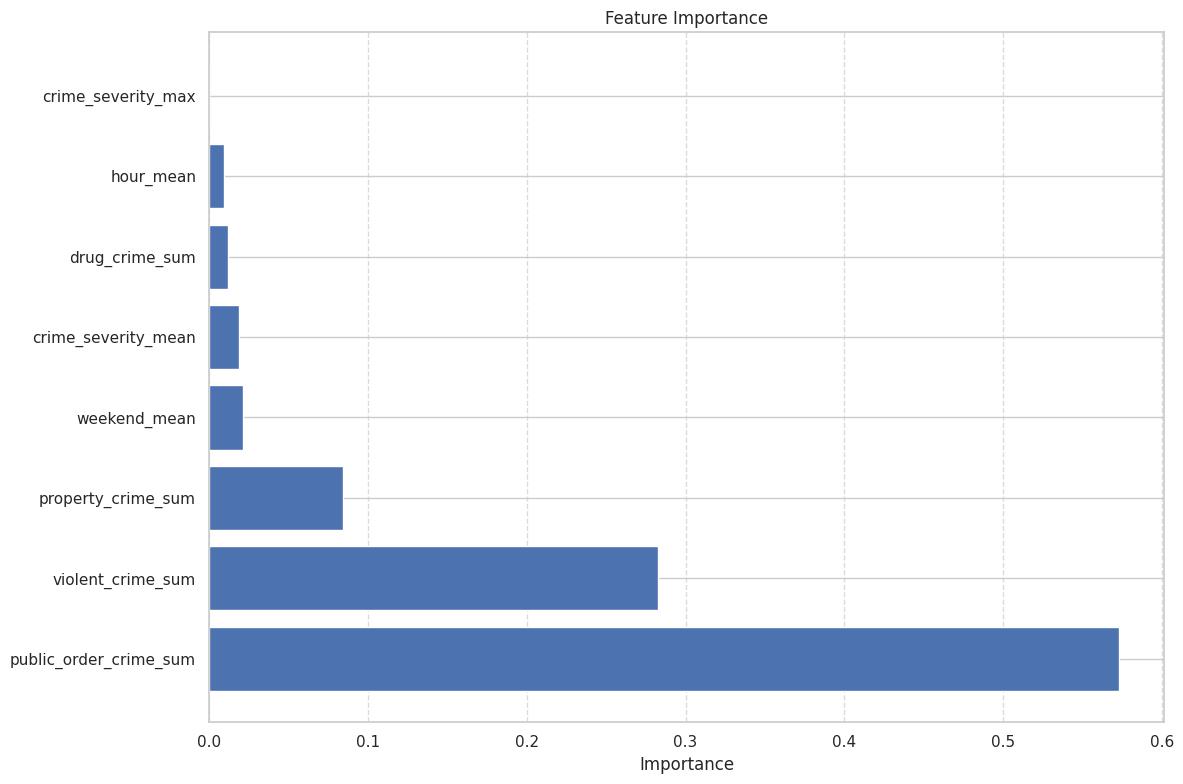

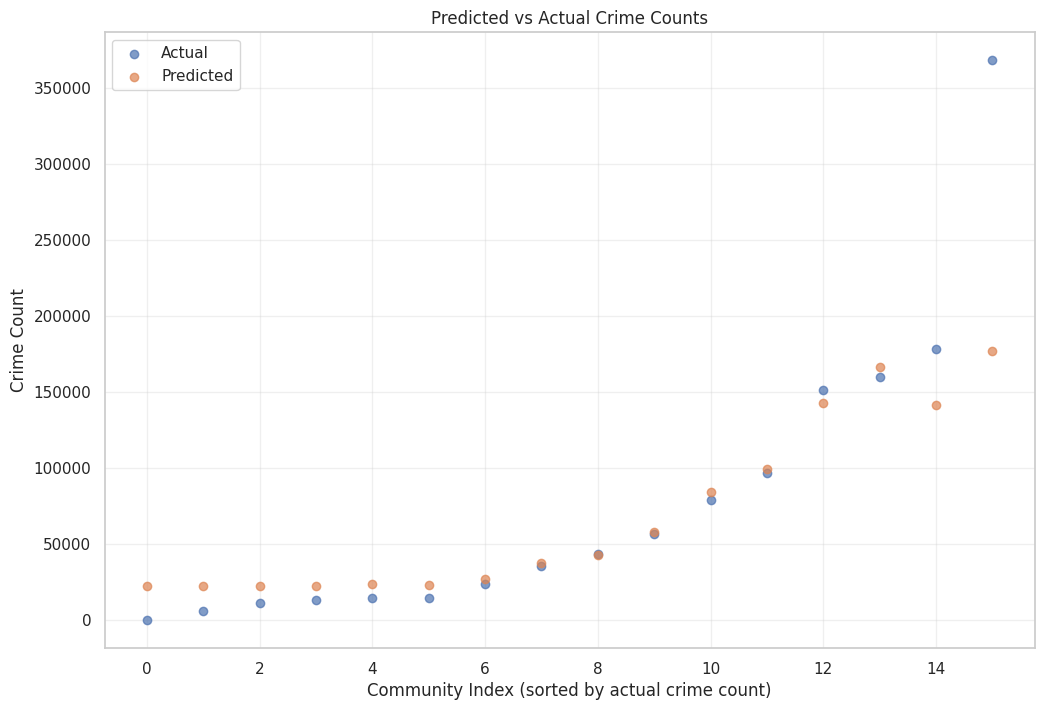

In [21]:
# Install required packages
!pip install xgboost folium matplotlib seaborn

# Import required libraries
import os
import gc
import time
import logging
import warnings
import numpy as np
import pandas as pd
import requests
from datetime import datetime
from tqdm.notebook import tqdm
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from google.colab import drive

# Mount Google Drive to save results
drive.mount('/content/drive')

# Configure warning handling
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# ---------------------------------------------------------------------
# CONFIGURATION
# ---------------------------------------------------------------------
class Config:
    def __init__(self):
        # Use Google Drive for persistent storage
        self.base_dir = "/content/drive/MyDrive/predictive_policing"
        self.data_dir = os.path.join(self.base_dir, "data")
        self.results_dir = os.path.join(self.base_dir, "results")
        self.logs_dir = os.path.join(self.base_dir, "logs")
        self.cache_dir = os.path.join(self.base_dir, "cache")
        self.viz_dir = os.path.join(self.results_dir, "visualizations")

        # Create directories
        for directory in [self.data_dir, self.results_dir, self.logs_dir,
                          self.cache_dir, self.viz_dir]:
            os.makedirs(directory, exist_ok=True)

        # Data loading parameters
        self.max_crime_records = 6000000  # Full dataset size
        self.batch_size = 500000  # Batch size for processing large datasets
        self.use_caching = True  # Enable data caching

        # Model parameters
        self.random_state = 42
        self.test_size = 0.2
        self.cv_folds = 5
        self.target = "crime_count"

        # Fairness analysis parameters - expanded to include all potential attributes
        self.protected_attributes = [
            "hardship_index", "per_capita_income", "pct_poverty",
            "pct_unemployed", "pct_no_hs_diploma", "pct_housing_crowded",
            "percent_aged_16_unemployed", "percent_aged_25_without_high_school_diploma",
            "percent_households_below_poverty", "per_capita_income"
        ]

        # API endpoints
        self.chicago_crime_api = "https://data.cityofchicago.org/resource/ijzp-q8t2.json"
        self.chicago_community_api = "https://data.cityofchicago.org/resource/igwz-8jzy.json"
        self.api_timeout = 60  # seconds - increased for larger dataset

        # Column mapping for standardization
        self.column_mapping = {
            "community_area": "community_area",
            "block": "block",
            "area_numbe": "community_area_id",
            "community": "community_name",
            "communityname": "community_name",
            "per_capita_income": "per_capita_income",
            "hardship_index": "hardship_index",
            "percent_households_below_poverty": "pct_poverty",
            "percent_aged_16_unemployed": "pct_unemployed",
            "percent_aged_25_without_high_school_diploma": "pct_no_hs_diploma",
            "percent_housing_crowded": "pct_housing_crowded"
        }

# Global configuration
CONFIG = Config()

# ---------------------------------------------------------------------
# LOGGER SETUP
# ---------------------------------------------------------------------
def setup_logger():
    logger = logging.getLogger("predictive_policing")
    if logger.handlers:
        return logger

    logger.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

    # Console handler
    ch = logging.StreamHandler()
    ch.setLevel(logging.INFO)
    ch.setFormatter(formatter)
    logger.addHandler(ch)

    # File handler
    log_file = os.path.join(CONFIG.logs_dir, f"pipeline_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log")
    fh = logging.FileHandler(log_file)
    fh.setLevel(logging.DEBUG)
    fh.setFormatter(formatter)
    logger.addHandler(fh)

    return logger

logger = setup_logger()

# ---------------------------------------------------------------------
# MEMORY MANAGEMENT
# ---------------------------------------------------------------------
def clear_memory():
    """Force garbage collection to free memory"""
    gc.collect()

def log_memory_usage():
    """Log current memory usage"""
    import psutil
    process = psutil.Process(os.getpid())
    memory_mb = process.memory_info().rss / (1024 * 1024)
    logger.info(f"Current memory usage: {memory_mb:.2f} MB")

# ---------------------------------------------------------------------
# DATA HELPERS
# ---------------------------------------------------------------------
def standardize_columns(df, mapping):
    """Standardize column names using mapping dictionary"""
    df = df.rename(columns={k: v for k, v in mapping.items() if k in df.columns})
    df.columns = df.columns.str.lower().str.strip()
    return df

def convert_numeric_columns(df, cols):
    """Convert specified columns to numeric type"""
    for col in cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

def downcast_dtypes(df):
    """Optimize memory usage by downcasting numeric types"""
    # Downcast float columns
    float_cols = df.select_dtypes(include=["float"]).columns
    for col in float_cols:
        df[col] = pd.to_numeric(df[col], downcast="float")

    # Downcast integer columns
    int_cols = df.select_dtypes(include=["int"]).columns
    for col in int_cols:
        df[col] = pd.to_numeric(df[col], downcast="integer")

    return df

# ---------------------------------------------------------------------
# DATA LOADING WITH CACHING AND CHUNKING FOR LARGE DATASETS
# ---------------------------------------------------------------------
def fetch_chicago_crime_data(use_cache=True, use_full_dataset=True):
    """Fetch Chicago crime data with caching"""
    cache_file = os.path.join(CONFIG.cache_dir, "chicago_crime_data.parquet")

    # Try to load from cache first
    if use_cache and os.path.exists(cache_file):
        try:
            logger.info(f"Loading Chicago crime data from cache")
            df = pd.read_parquet(cache_file)
            logger.info(f"Loaded {len(df):,} records from cache")
            return df
        except Exception as e:
            logger.warning(f"Failed to load from cache: {e}")

    # Fetch data from API in batches
    all_data = []
    offset = 0
    max_records = CONFIG.max_crime_records if use_full_dataset else 100000

    pbar = tqdm(desc="Fetching Chicago Crime Data", unit="rec")

    while True:
        params = {"$limit": CONFIG.batch_size, "$offset": offset}
        try:
            resp = requests.get(CONFIG.chicago_crime_api, params=params, timeout=CONFIG.api_timeout)
            resp.raise_for_status()
        except Exception as e:
            logger.error(f"Error at offset {offset}: {e}")
            break

        batch = resp.json()
        if not batch:
            break

        all_data.extend(batch)
        offset += CONFIG.batch_size
        pbar.update(len(batch))

        if offset >= max_records:
            break

        # Periodically save to cache during long downloads
        if len(all_data) % 1000000 == 0:
            logger.info(f"Downloaded {len(all_data):,} records so far...")

    pbar.close()
    logger.info(f"Fetched {len(all_data):,} Chicago crime records from API")

    # Convert to DataFrame
    df = pd.DataFrame(all_data)

    # Process date column
    if "date" in df.columns:
        try:
            df["date"] = pd.to_datetime(df["date"], errors="coerce")
        except Exception as e:
            logger.error(f"Error parsing date: {e}")

    # Standardize columns
    df = standardize_columns(df, CONFIG.column_mapping)

    # Convert numeric columns
    numeric_columns = ["community_area", "x_coordinate", "y_coordinate", "latitude", "longitude"]
    df = convert_numeric_columns(df, numeric_columns)

    # Save to cache
    if use_cache:
        try:
            df.to_parquet(cache_file, index=False, compression="snappy")
            logger.info(f"Saved Chicago crime data to cache")
        except Exception as e:
            logger.warning(f"Failed to save to cache: {e}")

    return df

def fetch_chicago_community_data(use_cache=True):
    """Fetch Chicago community data with caching"""
    cache_file = os.path.join(CONFIG.cache_dir, "chicago_community_data.parquet")

    # Try to load from cache first
    if use_cache and os.path.exists(cache_file):
        try:
            logger.info(f"Loading Chicago community data from cache")
            df = pd.read_parquet(cache_file)
            logger.info(f"Loaded {len(df):,} community records from cache")
            return df
        except Exception as e:
            logger.warning(f"Failed to load from cache: {e}")

    # Fetch data from API
    try:
        resp = requests.get(CONFIG.chicago_community_api, timeout=CONFIG.api_timeout)
        resp.raise_for_status()
    except Exception as e:
        logger.error(f"Error fetching community data: {e}")
        return pd.DataFrame()

    # Convert to DataFrame
    df = pd.DataFrame(resp.json())

    # Standardize columns
    df = standardize_columns(df, CONFIG.column_mapping)

    # Convert numeric columns
    numeric_columns = ["per_capita_income", "hardship_index", "pct_poverty", "pct_unemployed",
                       "pct_no_hs_diploma", "pct_housing_crowded"]
    df = convert_numeric_columns(df, numeric_columns)

    # Save to cache
    if use_cache:
        try:
            df.to_parquet(cache_file, index=False, compression="snappy")
            logger.info(f"Saved Chicago community data to cache")
        except Exception as e:
            logger.warning(f"Failed to save to cache: {e}")

    return df

# ---------------------------------------------------------------------
# PROCESS DATA IN CHUNKS FOR LARGE DATASETS
# ---------------------------------------------------------------------
def process_data_in_chunks(df, chunk_size=1000000, processor_func=None):
    """Process a large dataframe in chunks to save memory"""
    if df is None or processor_func is None:
        return df

    n_chunks = (len(df) + chunk_size - 1) // chunk_size
    logger.info(f"Processing dataframe in {n_chunks} chunks...")

    results = []
    for i in range(n_chunks):
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, len(df))

        logger.info(f"Processing chunk {i+1}/{n_chunks} (rows {start_idx}-{end_idx})")
        chunk = df.iloc[start_idx:end_idx].copy()

        # Process the chunk
        processed_chunk = processor_func(chunk)
        results.append(processed_chunk)

        # Clear memory
        del chunk
        clear_memory()

    # Combine results
    if results:
        if isinstance(results[0], pd.DataFrame):
            return pd.concat(results, ignore_index=True)
        else:
            return results
    return None

# ---------------------------------------------------------------------
# DATA CLEANING AND FEATURE ENGINEERING
# ---------------------------------------------------------------------
def clean_dataframe(df):
    """Clean and optimize a DataFrame"""
    if df is None or len(df) == 0:
        return df

    logger.info("Cleaning dataframe...")

    # Standardize column names
    df = standardize_columns(df, CONFIG.column_mapping)

    # Convert dictionary values to strings
    for col in df.select_dtypes(include=["object"]).columns:
        df[col] = df[col].apply(lambda x: str(x) if isinstance(x, dict) else x)

    # Drop duplicates
    df = df.drop_duplicates()

    # Fill missing numeric values with median
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].median())

    # Fill missing categorical values with mode
    cat_cols = df.select_dtypes(include=["object", "category"]).columns
    for col in cat_cols:
        if df[col].isnull().sum() > 0:
            mode_val = df[col].mode().iloc[0] if not df[col].mode().empty else "Unknown"
            df[col] = df[col].fillna(mode_val)

    # Optimize memory usage
    df = downcast_dtypes(df)

    return df

def create_temporal_features(df):
    """Create features from date column"""
    if 'date' not in df.columns:
        return df

    try:
        # Ensure date column is datetime
        df['date'] = pd.to_datetime(df['date'], errors='coerce')

        # Create time features
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df['day'] = df['date'].dt.day
        df['hour'] = df['date'].dt.hour
        df['dayofweek'] = df['date'].dt.dayofweek  # 0=Monday, 6=Sunday
        df['weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

        logger.info("Created temporal features")
    except Exception as e:
        logger.error(f"Error creating temporal features: {e}")

    return df

def create_crime_specific_features(df):
    """Create crime-specific features"""
    if 'primary_type' not in df.columns:
        return df

    try:
        # Create flags for major crime categories
        violent_crimes = ['HOMICIDE', 'ASSAULT', 'BATTERY', 'CRIMINAL SEXUAL ASSAULT', 'ROBBERY']
        property_crimes = ['BURGLARY', 'THEFT', 'MOTOR VEHICLE THEFT', 'ARSON']
        drug_crimes = ['NARCOTICS']
        public_order_crimes = ['PUBLIC PEACE VIOLATION', 'CRIMINAL TRESPASS', 'CRIMINAL DAMAGE']

        # Convert primary_type to uppercase for consistent comparison
        df['primary_type_upper'] = df['primary_type'].str.upper()

        # Create binary indicators
        df['violent_crime'] = df['primary_type_upper'].isin(violent_crimes).astype(int)
        df['property_crime'] = df['primary_type_upper'].isin(property_crimes).astype(int)
        df['drug_crime'] = df['primary_type_upper'].isin(drug_crimes).astype(int)
        df['public_order_crime'] = df['primary_type_upper'].isin(public_order_crimes).astype(int)

        # Create crime severity score (simplified example)
        severity_map = {
            'HOMICIDE': 10,
            'CRIMINAL SEXUAL ASSAULT': 9,
            'ROBBERY': 8,
            'AGGRAVATED ASSAULT': 7,
            'AGGRAVATED BATTERY': 7,
            'BURGLARY': 6,
            'MOTOR VEHICLE THEFT': 5,
            'THEFT': 4,
            'ARSON': 6,
            'NARCOTICS': 3,
            'WEAPONS VIOLATION': 6
        }

        # Create a default severity of 2 for unmapped crimes
        df['crime_severity'] = df['primary_type_upper'].map(
            lambda x: severity_map.get(x, 2)
        )

        # Remove temporary column
        df = df.drop(columns=['primary_type_upper'])

        logger.info("Created crime-specific features")
    except Exception as e:
        logger.error(f"Error creating crime-specific features: {e}")

    return df

# ---------------------------------------------------------------------
# DATA PROCESSOR CLASS
# ---------------------------------------------------------------------
class DataProcessor:
    def __init__(self):
        self.crime_data = None
        self.community_data = None
        self.merged_data = None

    def load_datasets(self, use_cache=True, use_full_dataset=True):
        """Load all datasets"""
        logger.info(f"Loading datasets (full_dataset={use_full_dataset})...")

        # Load crime data
        self.crime_data = fetch_chicago_crime_data(use_cache=use_cache, use_full_dataset=use_full_dataset)

        # Load community data (always load complete set)
        self.community_data = fetch_chicago_community_data(use_cache=use_cache)

        # Log dataset shapes
        if self.crime_data is not None:
            logger.info(f"Crime data shape: {self.crime_data.shape}")
        if self.community_data is not None:
            logger.info(f"Community data shape: {self.community_data.shape}")

        return self.crime_data, self.community_data

    def clean_data(self):
        """Clean all loaded datasets"""
        if self.crime_data is not None:
            # For large datasets, process in chunks
            if len(self.crime_data) > 1000000:
                self.crime_data = process_data_in_chunks(
                    self.crime_data,
                    chunk_size=1000000,
                    processor_func=clean_dataframe
                )
            else:
                self.crime_data = clean_dataframe(self.crime_data)

        if self.community_data is not None:
            self.community_data = clean_dataframe(self.community_data)

        logger.info("Data cleaning completed")
        return self

    def engineer_features(self):
        """Apply feature engineering to datasets"""
        if self.crime_data is not None:
            # For large datasets, process in chunks
            if len(self.crime_data) > 1000000:
                # Create temporal features
                self.crime_data = process_data_in_chunks(
                    self.crime_data,
                    chunk_size=1000000,
                    processor_func=create_temporal_features
                )

                # Create crime-specific features
                self.crime_data = process_data_in_chunks(
                    self.crime_data,
                    chunk_size=1000000,
                    processor_func=create_crime_specific_features
                )
            else:
                # Create temporal features
                self.crime_data = create_temporal_features(self.crime_data)

                # Create crime-specific features
                self.crime_data = create_crime_specific_features(self.crime_data)

        logger.info("Feature engineering completed")
        return self

    def merge_datasets(self):
        """Merge datasets with improved handling"""
        logger.info("Merging datasets...")

        if self.crime_data is None or self.community_data is None:
            logger.error("Missing required datasets for merging")
            return None

        # Ensure community_area is available
        if "community_area" in self.crime_data.columns:
            self.crime_data["community_area"] = self.crime_data["community_area"].astype(str).str.strip()
        elif "block" in self.crime_data.columns:
            # Try to extract community area from block
            self.crime_data["community_area"] = self.crime_data["block"].str.extract(r'(\d+)', expand=False)
        else:
            logger.error("Cannot extract community area from crime data.")
            return None

        # Aggregate crime data by community area
        logger.info("Aggregating crime data by community area...")

        # Define aggregation functions
        agg_functions = {
            'id': 'count'  # Total crime count
        }

        # Add crime type aggregations if available
        for col in ['violent_crime', 'property_crime', 'drug_crime', 'public_order_crime', 'crime_severity']:
            if col in self.crime_data.columns:
                if col == 'crime_severity':
                    agg_functions[col] = ['mean', 'max']
                else:
                    agg_functions[col] = 'sum'

        # Add temporal aggregations
        temporal_cols = ['weekend', 'hour']
        for col in temporal_cols:
            if col in self.crime_data.columns:
                agg_functions[col] = 'mean'

        # Aggregate by community area
        agg_crime = self.crime_data.groupby("community_area").agg(agg_functions)

        # Flatten multi-level column names if needed
        if isinstance(agg_crime.columns, pd.MultiIndex):
            agg_crime.columns = ['_'.join(col).strip() for col in agg_crime.columns.values]

        # Rename count column
        if 'id_count' in agg_crime.columns:
            agg_crime = agg_crime.rename(columns={'id_count': 'crime_count'})

        # Reset index to make community_area a regular column
        agg_crime = agg_crime.reset_index()

        logger.info(f"Aggregated crime data shape: {agg_crime.shape}")

        # Prepare community data for merging
        community_key = None
        for key in ["community_area", "area_numbe", "community_area_id"]:
            if key in self.community_data.columns:
                community_key = key
                break

        if community_key is None:
            logger.error("No suitable key found in community data for merging")
            return None

        # Ensure key column is properly formatted
        self.community_data[community_key] = self.community_data[community_key].astype(str).str.strip()

        # Merge crime and community data
        merged = pd.merge(
            agg_crime,
            self.community_data,
            left_on="community_area",
            right_on=community_key,
            how="left"
        )

        logger.info(f"Merged dataset shape: {merged.shape}")

        # Create interaction features
        merged = self.create_interaction_features(merged)

        # Optimize memory
        self.merged_data = downcast_dtypes(merged.copy())
        logger.info(f"Final merged dataset shape: {self.merged_data.shape}")

        return self.merged_data

    def create_interaction_features(self, df):
        """Create interaction features for modeling"""
        if df is None:
            return df

        try:
            # Create socioeconomic score if columns are available
            if all(x in df.columns for x in ['per_capita_income', 'hardship_index']):
                # Normalize values to 0-1 range
                df['per_capita_income_norm'] = (df['per_capita_income'] - df['per_capita_income'].min()) / (df['per_capita_income'].max() - df['per_capita_income'].min() + 1e-10)
                df['hardship_index_norm'] = df['hardship_index'] / 100  # Already on 0-100 scale

                # Create composite score (higher = better socioeconomic status)
                df['socioeconomic_score'] = df['per_capita_income_norm'] * (1 - df['hardship_index_norm'])

            # Create crime rate if population data available
            if 'population' in df.columns:
                df['crime_rate'] = df['crime_count'] / (df['population'] / 1000)

            # Create interactions between demographic and crime features
            if 'hardship_index' in df.columns and 'violent_crime_sum' in df.columns:
                df['hardship_violent_interaction'] = df['hardship_index'] * df['violent_crime_sum']

            if 'per_capita_income' in df.columns and 'property_crime_sum' in df.columns:
                df['income_property_interaction'] = df['per_capita_income'] * df['property_crime_sum']

            logger.info("Created interaction features")
        except Exception as e:
            logger.error(f"Error creating interaction features: {e}")

        return df

    def prepare_train_test_split(self, split_method='random'):
        """Prepare data for model training"""
        if self.merged_data is None:
            logger.error("Merged data is not available. Run merge_datasets() first.")
            return None, None, None, None

        # Determine target column
        if "crime_count" in self.merged_data.columns:
            target_col = "crime_count"
        elif CONFIG.target in self.merged_data.columns:
            target_col = CONFIG.target
        else:
            logger.error("No target column found in merged data.")
            return None, None, None, None

        # Extract features and target
        X = self.merged_data.drop(columns=[target_col], errors="ignore")
        y = self.merged_data[target_col]

        # For stratified split, we don't implement here but use random instead
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=CONFIG.test_size,
            random_state=CONFIG.random_state
        )

        logger.info(f"Train-test split: {X_train.shape} train, {X_test.shape} test")
        return X_train, X_test, y_train, y_test

    def prepare_model_features(self, X_train, X_test):
        """Prepare features for modeling with proper encoding and scaling"""
        # Get numeric and categorical columns
        numeric_cols = X_train.select_dtypes(include=[np.number]).columns
        cat_cols = X_train.select_dtypes(include=["object", "category"]).columns

        # Use only numeric features for simplicity in this implementation
        # Set up a proper preprocessing pipeline for production
        X_train_processed = X_train[numeric_cols].copy()
        X_test_processed = X_test[numeric_cols].copy()

        # Fill any remaining missing values
        X_train_processed = X_train_processed.fillna(0)
        X_test_processed = X_test_processed.fillna(0)

        logger.info(f"Prepared features with shape: train={X_train_processed.shape}, test={X_test_processed.shape}")

        return X_train_processed, X_test_processed, numeric_cols

# ---------------------------------------------------------------------
# MODELING CLASS
# ---------------------------------------------------------------------
class PredictiveModel:
    def __init__(self):
        self.model = None
        self.feature_importances = None
        self.performance_metrics = {}
        self.fairness_metrics = {}

    def build_model(self):
        """Build XGBoost model with regularization parameters"""
        logger.info("Building XGBoost model...")

        # Create model with parameters to prevent overfitting
        self.model = xgb.XGBRegressor(
            n_estimators=100,
            max_depth=4,
            learning_rate=0.03,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,  # L1 regularization
            reg_lambda=1.0,  # L2 regularization
            random_state=CONFIG.random_state
        )

        return self.model

    def train_model(self, X_train, y_train, feature_names=None):
        """Train the model with cross-validation"""
        if self.model is None:
            self.build_model()

        logger.info("Training model...")

        # Calculate cross-validation score
        cv_scores = cross_val_score(
            self.model,
            X_train,
            y_train,
            cv=CONFIG.cv_folds,
            scoring="r2"
        )

        logger.info(f"CV R² scores: {cv_scores}")
        logger.info(f"Mean CV R²: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

        # Fit the model on the full training set
        self.model.fit(X_train, y_train)

        # Extract feature importances
        if hasattr(self.model, "feature_importances_"):
            if feature_names is not None:
                # Create Series with feature names
                self.feature_importances = pd.Series(
                    self.model.feature_importances_,
                    index=feature_names
                ).sort_values(ascending=False)
            else:
                # No feature names provided
                self.feature_importances = pd.Series(
                    self.model.feature_importances_
                ).sort_values(ascending=False)

            # Log top features
            logger.info("Top feature importances:")
            for feat, imp in self.feature_importances.head(5).items():
                logger.info(f"  {feat}: {imp:.4f}")

        return self.model

    def evaluate_model(self, X_test, y_test):
        """Evaluate the model with comprehensive metrics"""
        if self.model is None:
            logger.error("Model not trained; cannot evaluate")
            return None, None

        logger.info("Evaluating model...")

        # Generate predictions
        y_pred = self.model.predict(X_test)

        # Calculate performance metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)

        # Store metrics
        self.performance_metrics = {
            "MSE": mse,
            "RMSE": rmse,
            "R²": r2,
            "MAE": mae
        }

        # Log performance
        logger.info(f"Model performance: MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

        return self.performance_metrics, y_pred

    def analyze_fairness(self, X_test, y_test, y_pred, protected_attrs=None):
        """Perform fairness analysis across protected attributes"""
        logger.info("Performing fairness analysis...")

        # Use default protected attributes if none provided
        if protected_attrs is None:
            protected_attrs = CONFIG.protected_attributes

        # Find available protected attributes in test data
        available_attrs = [attr for attr in protected_attrs if attr in X_test.columns]

        if not available_attrs:
            logger.warning("No protected attributes found in test data")
            return {}

        fairness_results = {}

        # Analyze each attribute
        for attr in available_attrs:
            try:
                # Ensure attribute is numeric
                if not pd.api.types.is_numeric_dtype(X_test[attr]):
                    logger.info(f"{attr} is not numeric; skipping")
                    continue

                # Create groups by quartiles
                try:
                    # Get quartile bins while handling duplicate values
                    groups = pd.qcut(X_test[attr], 4, duplicates='drop')
                except ValueError:
                    # If we get an error, try with fewer bins
                    unique_vals = X_test[attr].nunique()
                    if unique_vals < 4:
                        groups = pd.Categorical(X_test[attr])
                    else:
                        groups = pd.qcut(X_test[attr], min(unique_vals, 3), duplicates='drop')

                # Calculate metrics by group
                group_metrics = {}
                for group_name, group_df in X_test.groupby(groups):
                    # Get indices for this group
                    indices = group_df.index

                    # Skip small groups
                    if len(indices) < 3:
                        logger.info(f"Skipping small group {group_name} for {attr} (n={len(indices)})")
                        continue

                    # Get actual and predicted values
                    group_y_test = y_test.iloc[indices]
                    group_y_pred = y_pred[indices]

                    # Calculate error metrics
                    rmse = np.sqrt(mean_squared_error(group_y_test, group_y_pred))
                    mae = mean_absolute_error(group_y_test, group_y_pred)
                    r2 = r2_score(group_y_test, group_y_pred) if len(indices) > 1 else np.nan

                    # Store metrics
                    group_metrics[str(group_name)] = {
                        'count': len(indices),
                        'rmse': rmse,
                        'mae': mae,
                        'r2': r2
                    }

                # Calculate disparity metrics
                if len(group_metrics) >= 2:
                    # Get error metrics across groups
                    rmse_values = [m['rmse'] for m in group_metrics.values()]
                    mae_values = [m['mae'] for m in group_metrics.values()]

                    # Calculate min-max ratios (closer to 1 = more fair)
                    rmse_ratio = min(rmse_values) / max(rmse_values) if max(rmse_values) > 0 else 0
                    mae_ratio = min(mae_values) / max(mae_values) if max(mae_values) > 0 else 0

                    # Store fairness metrics
                    fairness_results[attr] = {
                        'rmse_disparity_ratio': rmse_ratio,
                        'mae_disparity_ratio': mae_ratio,
                        'group_metrics': group_metrics
                    }

                    logger.info(f"Fairness metrics for {attr}: RMSE ratio = {rmse_ratio:.4f}, MAE ratio = {mae_ratio:.4f}")
                else:
                    logger.warning(f"Not enough groups for fairness analysis of {attr}")

            except Exception as e:
                logger.error(f"Error in fairness analysis for {attr}: {e}")

        # Store fairness metrics
        self.fairness_metrics = fairness_results

        return fairness_results

# ---------------------------------------------------------------------
# VISUALIZATION FUNCTIONS
# ---------------------------------------------------------------------
def plot_feature_importance(model, feature_names=None, top_n=10):
    """Plot feature importance from model"""
    if not hasattr(model, 'feature_importances_'):
        logger.error("Model doesn't have feature importances")
        return None

    logger.info("Creating feature importance plot...")

    # Get feature importances
    importances = model.feature_importances_

    # Create feature names if not provided
    if feature_names is None:
        feature_names = [f'Feature {i}' for i in range(len(importances))]
    elif isinstance(feature_names, pd.Index):
        feature_names = feature_names.tolist()

    # Create DataFrame for plotting
    imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    # Limit to top N features
    if len(imp_df) > top_n:
        imp_df = imp_df.head(top_n)

    # Create figure
    plt.figure(figsize=(12, 8))

    # Plot horizontal bar chart
    plt.barh(
        np.arange(len(imp_df)),
        imp_df['Importance'],
        align='center'
    )

    # Add labels
    plt.yticks(np.arange(len(imp_df)), imp_df['Feature'])
    plt.xlabel('Importance')
    plt.title('Feature Importance')

    # Add grid
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Save figure
    plot_path = os.path.join(CONFIG.viz_dir, 'feature_importance.png')
    plt.savefig(plot_path)

    logger.info(f"Feature importance plot saved to {plot_path}")
    return plt

def plot_fairness_metrics(fairness_results):
    """Plot fairness metrics by protected attribute"""
    if not fairness_results:
        logger.warning("No fairness metrics to plot")
        return None

    logger.info("Creating fairness metrics plot...")

    # Extract metrics
    attributes = []
    rmse_ratios = []
    mae_ratios = []

    for attr, metrics in fairness_results.items():
        attributes.append(attr)
        rmse_ratios.append(metrics.get('rmse_disparity_ratio', 0))
        mae_ratios.append(metrics.get('mae_disparity_ratio', 0))

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot RMSE ratios
    ax1.barh(attributes, rmse_ratios)
    ax1.set_title('RMSE Disparity Ratio by Protected Attribute')
    ax1.set_xlabel('Ratio (closer to 1 = more fair)')
    ax1.axvline(x=1, color='green', linestyle='--', alpha=0.5)
    ax1.set_xlim(0, 1.1)

    # Plot MAE ratios
    ax2.barh(attributes, mae_ratios)
    ax2.set_title('MAE Disparity Ratio by Protected Attribute')
    ax2.set_xlabel('Ratio (closer to 1 = more fair)')
    ax2.axvline(x=1, color='green', linestyle='--', alpha=0.5)
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    # Save figure
    plot_path = os.path.join(CONFIG.viz_dir, 'fairness_metrics.png')
    plt.savefig(plot_path)

    logger.info(f"Fairness metrics plot saved to {plot_path}")
    return plt

def plot_predictions_vs_actual(y_test, y_pred, community_names=None):
    """Plot predicted vs actual values"""
    if y_test is None or y_pred is None or len(y_test) != len(y_pred):
        logger.error("Invalid data for predictions plot")
        return None

    logger.info("Creating predictions vs actual plot...")

    # Create figure
    plt.figure(figsize=(12, 8))

    # Get indices for plotting
    indices = np.arange(len(y_test))

    # Sort by actual values for better visualization
    if isinstance(y_test, pd.Series):
        sort_indices = y_test.argsort()
        y_test_sorted = y_test.iloc[sort_indices]
        y_pred_sorted = y_pred[sort_indices]
    else:
        sort_indices = np.argsort(y_test)
        y_test_sorted = y_test[sort_indices]
        y_pred_sorted = y_pred[sort_indices]

    # Plot actual and predicted values
    plt.scatter(indices, y_test_sorted, label='Actual', alpha=0.7)
    plt.scatter(indices, y_pred_sorted, label='Predicted', alpha=0.7)

    # Add labels
    plt.xlabel('Community Index (sorted by actual crime count)')
    plt.ylabel('Crime Count')
    plt.title('Predicted vs Actual Crime Counts')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Save figure
    plot_path = os.path.join(CONFIG.viz_dir, 'predictions_vs_actual.png')
    plt.savefig(plot_path)

    logger.info(f"Predictions plot saved to {plot_path}")
    return plt

# ---------------------------------------------------------------------
# MAIN EXECUTION FUNCTION
# ---------------------------------------------------------------------
def run_pipeline(use_full_dataset=True, use_cache=True):
    """Run the predictive policing pipeline"""
    start_time = time.time()
    logger.info(f"Starting predictive policing pipeline (full_dataset={use_full_dataset})")

    try:
        # Initialize data processor
        dp = DataProcessor()

        # Step 1: Load datasets
        dp.load_datasets(use_cache=use_cache, use_full_dataset=use_full_dataset)

        # Log memory usage
        log_memory_usage()

        # Step 2: Clean data
        dp.clean_data()

        # Step 3: Engineer features
        dp.engineer_features()

        # Step 4: Merge datasets
        merged_df = dp.merge_datasets()
        if merged_df is None:
            logger.error("Failed to create merged dataset")
            return None

        # Step 5: Prepare train/test split
        X_train, X_test, y_train, y_test = dp.prepare_train_test_split()
        if X_train is None:
            logger.error("Failed to create train/test split")
            return None

        # Step 6: Prepare model features
        X_train_processed, X_test_processed, feature_names = dp.prepare_model_features(X_train, X_test)
        if X_train_processed is None:
            logger.error("Failed to prepare model features")
            return None

        # Step 7: Build and train model
        model = PredictiveModel()
        model.build_model()
        model.train_model(X_train_processed, y_train, feature_names=feature_names)

        # Step 8: Evaluate model
        performance, y_pred = model.evaluate_model(X_test_processed, y_test)
        logger.info(f"Model Performance: {performance}")

        # Step 9: Analyze fairness
        fairness_results = model.analyze_fairness(X_test, y_test, y_pred)

        # Step 10: Create visualizations
        plot_feature_importance(model.model, feature_names)
        plot_fairness_metrics(fairness_results)
        plot_predictions_vs_actual(y_test, y_pred)

        # Calculate elapsed time
        elapsed_time = time.time() - start_time
        logger.info(f"Pipeline completed in {elapsed_time:.1f} seconds")

        # Return results
        return {
            "data_processor": dp,
            "model": model,
            "performance": performance,
            "fairness_results": fairness_results,
            "X_train": X_train,
            "X_test": X_test,
            "y_train": y_train,
            "y_test": y_test,
            "y_pred": y_pred,
            "feature_names": feature_names,
            "elapsed_time": elapsed_time
        }

    except Exception as e:
        logger.exception(f"Error in pipeline execution: {e}")
        return None

# ---------------------------------------------------------------------
# EXECUTE PIPELINE
# ---------------------------------------------------------------------
# Run the full pipeline
results = run_pipeline(use_full_dataset=True, use_cache=True)

if results:
    print("Pipeline execution successful!")
    print(f"Model performance: {results['performance']}")
    print(f"Execution time: {results['elapsed_time']:.1f} seconds")

    # Show top features
    print("\nTop 10 important features:")
    print(results['model'].feature_importances.head(10))
else:
    print("Pipeline execution failed.")